# Marelle Board import
* Getting players info dict => `MarelleBoard.players`
* 3 phases : place, move and end => `MarelleBoard.phase`
* Reset the board => `MarelleBoard.initialize_game()`
* Printing the board => `MarelleBoard.print_board()`
* Id:Action dict => `MarelleBoard.id_to_action`
* Action:Id dict => `MarelleBoard.action_to_id`
* Get the board state => `MarelleBoard.get_state()`
* Play an action => `MarelleBoard.play_action(action_id, player)`
* Get legal action ids => `MarelleBoard.get_legal_action_ids(player)`
* Check if game ended (returns 0 if not ended or winning player id) : `MarelleBoard.check_if_end(player)`

In [1]:
from maRL_board import MarelleBoard

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim
import itertools

In [2]:
board=MarelleBoard()
board.print_board()
a=board.get_legal_action_ids(1)[0]
board.play_action(a,1)
board.print_board()
b=board.get_legal_action_ids(-1)[2]
print(board.id_to_action[b])
board.play_action(b,-1)
board.print_board()


        Phase : place
        Placed tokens : P1 : 0 / P2 : 0 
        Tokens on board : P1 : 0 / P2 : 0 
        0--------------0--------------0
        |              |              |
        |    0---------0---------0    |
        |    |         |         |    |
        |    |    0----0----0    |    |
        |    |    |         |    |    |
        0----0----0         0----0----0                 
        |    |    |         |    |    |
        |    |    0----0----0    |    |
        |    |         |         |    |
        |    0---------0---------0    |
        |              |              |
        0--------------0--------------0
        

        Phase : place
        Placed tokens : P1 : 1 / P2 : 0 
        Tokens on board : P1 : 1 / P2 : 0 
        0--------------0--------------0
        |              |              |
        |    0---------0---------0    |
        |    |         |         |    |
        |    |    0----0----0    |    |
        |    |    |         |    |    |


In [4]:
import gym
from gym import spaces


class MarelleGymEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}
    def __init__(self):
        super(MarelleGymEnv, self).__init__()    
    
    # Define action and observation space
    # They must be gym.spaces objects
        self.board = MarelleBoard()
        self.action_space = spaces.Discrete(len(self.board.id_to_action))    # Example for using image as input:
        self.observation_space = spaces.Discrete(len(self.board.get_state()))
        self.list_move = []
        self.current_player = 1
        
    def step(self, action): 
   
        self.board.play_action(action,self.current_player)

        observation=self.board.get_state()
        done = self.board.check_if_end(self.current_player) != 0
        reward = self.board.check_if_end(self.current_player)*self.current_player
        self.list_move.append(action)
        info = ""
        self.current_player = self.board.get_opponent(self.current_player)

        return observation, reward, done, info
    
    # Execute one time step within the environment
  
    def reset(self):
        self.current_player = 1
        self.list_move = []
        self.board.initialize_game()

        return self.board.get_state()
    # Reset

    def render(self, mode='human', close=False):
        self.board.print_board()



### Création d'une classse générale agent dont nos agents seront hérités

In [48]:
class Model(nn.Module):
    def __init__(self, dim_observation, n_actions):
        super(Model, self).__init__()
        
        self.n_actions = n_actions
        self.dim_observation = dim_observation
        
        self.net = nn.Sequential(
            nn.Linear(in_features=self.dim_observation, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=self.n_actions),
            nn.Softmax(dim=0)
        )
        
    def forward(self, state):
        return self.net(state)
    
   # def select_action(self, state):
    #    action = torch.multinomial(self.forward(state), 1)
     #   return action

In [55]:
class Agent(object):
    def __init__(self, env, player_id, epsilon=0):
        self.epsilon = epsilon
        self.env = env
        self.n_action = len(self.env.board.id_to_action)
        self.model = Model(len(self.env.board.get_state()), self.n_action)
        self.gamma = 1
        self.player_id = player_id
        self.optimizer = torch.optim.Adam(self.model.net.parameters(), lr=0.01)
        
    def set_epsilon(self,e):
        self.epsilon = e

    def act(self,s,train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else: # in some cases, this can improve the performance.. remove it if poor performances
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    
    def _compute_returns(self, rewards):
        """Returns the cumulative discounted rewards at each time step
        
        Parameters
        ----------
        rewards : array
            The array of rewards of one episode

        Returns
        -------
        array
            The cumulative discounted rewards at each time step
            
        Example
        -------
        for rewards=[1, 2, 3] this method outputs [1 + 2 * gamma + 3 * gamma**2, 2 + 3 * gamma, 3] 
        """
        raise NotImplementedError
        
    def optimize_model(self, n_trajectories, adversaire):
        """Perform a gradient update using n_trajectories

        Parameters
        ----------
        n_trajectories : int
            The number of trajectories used to approximate the expectation card(D) in the formula above

        Returns
        -------
        array
            The cumulative discounted rewards of each trajectory
        """
        
        raise NotImplementedError
    
    def train(self, n_trajectories, n_update, adversaire):
        """Training method

        Parameters
        ----------
        n_trajectories : int
            The number of trajectories used to approximate the expected gradient
        n_update : int
            The number of gradient updates
            
        """
        rewards = []
        for episode in range(n_update):
            rewards.append(self.optimize_model(n_trajectories, adversaire))
            #print(episode)
            if (episode+1)%5 == 0:
                print(f'Episode {episode + 1}/{n_update}: rewards {round(np.mean(rewards[-1]), 2)} +/- {round(np.std(rewards[-1]), 2)}')
        
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards[i]) for i in range(len(rewards))))), columns=['Epoch', 'Reward'])
        sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
    
    
    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

### Notre premier enfant

In [56]:
class RandomAgent(Agent):
    def __init__(self, env, player_id):
        super(RandomAgent, self).__init__(env, player_id)
        pass

    def learned_act(self, s):
        return(np.random.choice(self.env.board.get_legal_action_ids(self.player_id)))

class BetterRandomAgent(Agent):
    def __init__(self, env, player_id):
        super(BetterRandomAgent, self).__init__(env, player_id)
        pass

    def learned_act(self, s):
        legal_actions = self.env.board.get_legal_actions(self.player_id)
        opponent_legal_actions = self.env.board.get_legal_actions(self.env.board.get_opponent(self.player_id))
        
        pos_to_block = []
        for opponent_action in opponent_legal_actions:
            # Check positions we should block
            _, pos = opponent_action
            if pos != None:
                pos_to_block.append(pos)

        blocker_action = None
        for action in legal_actions:
            # Check if possible to capture
            pos, enemy_pos = action
            if enemy_pos != None:
                return self.env.board.action_to_id[action]
            
            # Check if possible to block
            if self.env.board.phase == "place":
                if pos in pos_to_block:
                    blocker_action = action
            
            elif self.env.board.phase == "move":
                a, b = pos
                if a in pos_to_block or b in pos_to_block:
                    blocker_action = action
        
        if blocker_action != None:
            return self.env.board.action_to_id[blocker_action]
        
        return(np.random.choice(self.env.board.get_legal_action_ids(self.player_id)))
    

### Agent REINFORCE

In [65]:
einstein.env.board.print_board()
[p for p in einstein.model.parameters()]


        Phase : place
        Placed tokens : P1 : 0 / P2 : 0 
        Tokens on board : P1 : 0 / P2 : 0 
        0--------------0--------------0
        |              |              |
        |    0---------0---------0    |
        |    |         |         |    |
        |    |    0----0----0    |    |
        |    |    |         |    |    |
        0----0----0         0----0----0                 
        |    |    |         |    |    |
        |    |    0----0----0    |    |
        |    |         |         |    |
        |    0---------0---------0    |
        |              |              |
        0--------------0--------------0
        


[Parameter containing:
 tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

In [58]:
import seaborn as sns
import pandas as pd
import numpy as np
env=MarelleGymEnv()
einstein=Reinforce(env,1)
piccolo=RandomAgent(env,-1)
piccolo_brain=BetterRandomAgent(env,-1)

einstein.train(1000,100, adversaire = piccolo_brain)
#TO DO
#random agent, random qui prend quand il faut
#learning rate ? config
#calibrage rewards 
#CNN avec le bon
#reward à 100

Episode 5/100: rewards -0.66 +/- 0.75
Episode 10/100: rewards -0.48 +/- 0.88
Episode 15/100: rewards -0.3 +/- 0.95
Episode 20/100: rewards -0.11 +/- 0.99
Episode 25/100: rewards 0.13 +/- 0.99
Episode 30/100: rewards 0.14 +/- 0.99
Episode 35/100: rewards 0.19 +/- 0.98
Episode 40/100: rewards 0.27 +/- 0.96
Episode 45/100: rewards 0.25 +/- 0.97


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

In [57]:
class Reinforce(Agent):
    def __init__(self,env, player_id):
        super(Reinforce, self).__init__(env, player_id)
        pass

    def learned_act(self, s): #checker legal move + argmax
        legal_moves = self.env.board.get_legal_action_ids(self.player_id)
        t_all_moves=np.array(self.model(s).detach())
        t_legal_moves =[t_all_moves[legal_move] for legal_move in legal_moves]
        argm = np.argmax(t_legal_moves)
        action = legal_moves[argm]

        return(action) 
        
    def _compute_returns(self, rewards):
        
        returns=0
        for i in range(len(rewards)):
            returns=self.gamma*returns+rewards[-(i+1)]
        return(returns)
               
    def optimize_model(self, n_trajectories, adversaire): #adversaire on met dedans l'agent qui jouera contre
      
        reward_trajectories=[]
        list_sum_proba=[]
        
        #Here I compute n_trajectories trajectories in order to calculate the MonteCarlo estimate of the J function
        for i in range(n_trajectories):
            done = False
            rewards=[]

            state=self.env.reset()
            state=torch.tensor(state, dtype=torch.float)
            
            sum_lprob=0
            while not done:
                
                
                legal_moves = self.env.board.get_legal_action_ids(self.player_id)
                t_all_moves = self.model(state)
                t_legal_moves = torch.tensor([t_all_moves[legal_move] for legal_move in legal_moves])
                action_id = int(torch.multinomial(t_legal_moves, 1))
                action = legal_moves[action_id]
                
                sum_lprob+= t_all_moves[action].log()
                state, reward_p1, done, info =self.env.step(action)
                
                
                #au tour de l'adversaire
                if not done:
                    action=adversaire.act(state)
                    state, reward_p2, done, info = self.env.step(action)
                    rewards.append(reward_p1-reward_p2)
                else : 
                    rewards.append(reward_p1)
                    
                state=torch.tensor(state, dtype=torch.float)
            
            list_sum_proba.append(sum_lprob)
            reward_trajectories.append(self._compute_returns(rewards))
        
        loss=0
        for i in range(len(list_sum_proba)):
            loss+=-list_sum_proba[i]*reward_trajectories[i]
        
        loss=loss/len(list_sum_proba)
       
        # The following lines take care of the gradient descent step for the variable loss
        # Discard previous gradients
        self.optimizer.zero_grad()
        # Compute the gradient 
        loss.backward()
        # Do the gradient descent step
        self.optimizer.step()
        
        return reward_trajectories

### Jouons

* Getting players info dict => `MarelleBoard.players`
* 3 phases : place, move and end => `MarelleBoard.phase`
* Reset the board => `MarelleBoard.initialize_game()`
* Printing the board => `MarelleBoard.print_board()`
* Id:Action dict => `MarelleBoard.id_to_action`
* Action:Id dict => `MarelleBoard.action_to_id`
* Get the board state => `MarelleBoard.get_state()`
* Play an action => `MarelleBoard.play_action(action_id, player)`
* Get legal action ids => `MarelleBoard.get_legal_action_ids(player)`
* Check if game ended (returns 0 if not ended or winning player id) : `MarelleBoard.check_if_end()`

In [38]:
import progressbar as pb
import numpy as np

compteur_partie=0
compteur_piccolo=0
compteur_gabrielle=0

n_partie = 100
n_tour = 500
n_pion_p1 = np.zeros((n_partie,2*n_tour))
n_pion_p2 = np.zeros((n_partie,2*n_tour))
list_n_coup_joue=[]

for j in range(n_partie): #(n parties)
    marelle_env = MarelleGymEnv()
    piccolo= RandomAgent(marelle_env,1)
    gabrielle = RandomAgent(marelle_env,-1)

    compteur_partie+=1
    pion_p1 = np.zeros(2*n_tour)
    pion_p2 = np.zeros(2*n_tour)
    n_coup_joue=0
    for i in range (n_tour):

        s=marelle_env.board.get_state()
        a_p1 = piccolo.act(s,train = False)
        s, reward, done, info = marelle_env.step(a_p1)
        pion_p1[i]=marelle_env.board.players[1]["tokens_on_board"]
        pion_p2[i] = marelle_env.board.players[-1]["tokens_on_board"]
        n_coup_joue+=1
        if done:
            #print('Piccolo win fatality')
            compteur_piccolo+=1
            list_n_coup_joue.append(n_coup_joue)
            break

        #marelle_env.render()

        a_p2 = gabrielle.act(s,train = False)
        s, reward, done, info = marelle_env.step(a_p2)
        pion_p1[i] = marelle_env.board.players[1]["tokens_on_board"]
        pion_p2[i] = marelle_env.board.players[-1]["tokens_on_board"]
        n_coup_joue+=1
        if done :
            #print('gabrielle win encore..')
            compteur_gabrielle+=1
            list_n_coup_joue.append(n_coup_joue)
            break
    
    n_pion_p1[j]= pion_p1
    n_pion_p2[j]= pion_p2    
        #marelle_env.render()
 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


100 47 53
81.41
64.34160318176724


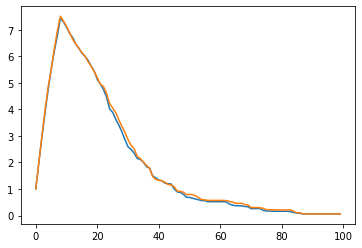

In [46]:
import matplotlib.pyplot as plt
print(compteur_partie, compteur_piccolo, compteur_gabrielle)
print(np.mean(list_n_coup_joue))
print(np.std(list_n_coup_joue))
plt.plot(np.mean(n_pion_p1,axis = 0)[:100])
plt.plot(np.mean(n_pion_p2,axis = 0)[:100])
plt.show()

In [18]:
import cProfile
def boucles(n_partie,n_tour):
    for j in range(n_partie): #(n parties)
        marelle_env = MarelleGymEnv()
        piccolo= RandomAgent(marelle_env.board,1)
        gabrielle = RandomAgent(marelle_env.board,-1)

        for i in range (n_tour):

            s=marelle_env.board.get_state()
            a_p1 = piccolo.act(s,train = False)
            s, reward, done, info = marelle_env.step(a_p1)
            if done:
                #print('Piccolo win fatality')
                break

            a_p2 = gabrielle.act(s,train = False)
            s, reward, done, info = marelle_env.step(a_p2)
            if done :
                #print('gabrielle win encore..')
                break 
        

In [19]:
cProfile.run("boucles(100,130)")

         471080012 function calls (384196460 primitive calls) in 132.630 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      200    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(concatenate)
     7255    0.005    0.000   66.159    0.009 <ipython-input-13-c9cd4e13515a>:11(act)
      200    0.000    0.000    0.000    0.000 <ipython-input-13-c9cd4e13515a>:2(__init__)
      200    0.000    0.000    0.000    0.000 <ipython-input-14-18967b4e80bd>:2(__init__)
     7255    0.020    0.000   66.154    0.009 <ipython-input-14-18967b4e80bd>:6(learned_act)
        1    0.024    0.024  132.630  132.630 <ipython-input-18-230384b5c51d>:2(boucles)
     7255    0.028    0.000   66.194    0.009 <ipython-input-7-abcc0e7cf1ff>:15(step)
      100    0.001    0.000    0.140    0.001 <ipython-input-7-abcc0e7cf1ff>:4(__init__)
        1    0.000    0.000  132.630  132.630 <string>:1(<module>)
      200    0.000    0.000    0.0